# Import libraries

In [1]:
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.contrib.keras.python.keras.optimizers import Adam
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping
from tensorflow.contrib.keras.python.keras.regularizers import l1, l2

import numpy as np
import matplotlib.pyplot as plt

# Load dataset

In [2]:
trainingset = np.loadtxt('fer2013_training_onehot.csv', delimiter=',')
testingset = np.loadtxt('fer2013_publictest_onehot.csv', delimiter=',')

# Split data

In [3]:
n_inputs = 2304
n_classes = 7
img_dim = 48

x_training = trainingset[:, 0:n_inputs]
y_training = trainingset[:, n_inputs:n_inputs + n_classes]

x_testing = testingset[:, 0:n_inputs]
y_testing = testingset[:, n_inputs:n_inputs + n_classes]

x_training = x_training.reshape(x_training.shape[0], 48, 48)
x_training = np.expand_dims(x_training, axis=4)

x_testing = x_testing.reshape(x_testing.shape[0], 48, 48)
x_testing = np.expand_dims(x_testing, axis=4)

In [98]:
def get_emotion(ohv):
    if ohv.shape[0] == 1:
        indx = ohv[0]
    else:
        indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

(28709, 48, 48, 1)
(28709, 7)
(3589, 48, 48, 1)
(3589, 7)


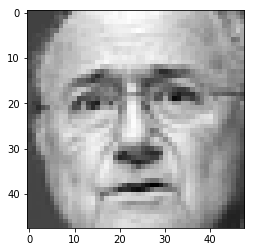

hey 2
facial emotion: fear


In [65]:
print(x_training.shape)
print(y_training.shape)

print(x_testing.shape)
print(y_testing.shape)

sample = x_training[5, :]
sample = sample.reshape(48, 48)

plt.imshow(sample, cmap='gray')
plt.show()
print('facial emotion: %s' % get_emotion(y_training[5, :]))

# Define model: a model in karas is a sequence of layers!

In [10]:
model = Sequential()

In [11]:
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape = (48, 48, 1)))

In [12]:
model.add(Conv2D(64, (3, 3), activation='relu'))

In [13]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [14]:
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

In [15]:
model.add(Conv2D(128, (3, 3), activation='relu'))

In [17]:
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

In [18]:
model.add(Conv2D(256, (3, 3), activation='relu'))

In [19]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [20]:
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# Compile model

In [21]:
opt = Adam(lr=0.0001, decay=10e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit model

In [63]:
batch_size = 128
n_epoches = 500
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

model.fit(x_training, y_training, batch_size=batch_size, epochs=n_epoches,
          validation_data=(x_testing, y_testing), shuffle=True,
          callbacks=[early_stopping])

Train on 28709 samples, validate on 3589 samples
Epoch 1/500
28709/28709 [==============================] - 28s - loss: 4.6490 - acc: 0.2538 - val_loss: 3.1333 - val_acc: 0.3260
Epoch 2/500
28709/28709 [==============================] - 27s - loss: 2.8764 - acc: 0.3723 - val_loss: 2.6314 - val_acc: 0.4302
Epoch 3/500
28709/28709 [==============================] - 27s - loss: 2.4925 - acc: 0.4468 - val_loss: 2.3041 - val_acc: 0.4940
Epoch 4/500
28709/28709 [==============================] - 28s - loss: 2.2192 - acc: 0.4982 - val_loss: 2.1024 - val_acc: 0.5107
Epoch 5/500
28709/28709 [==============================] - 27s - loss: 2.0095 - acc: 0.5367 - val_loss: 1.9508 - val_acc: 0.5316
Epoch 6/500
28709/28709 [==============================] - 28s - loss: 1.8300 - acc: 0.5715 - val_loss: 1.8335 - val_acc: 0.5419
Epoch 7/500
28709/28709 [==============================] - 28s - loss: 1.6758 - acc: 0.6046 - val_loss: 1.7223 - val_acc: 0.5704
Epoch 8/500
28709/28709 [=======================

# Evaluate model

In [64]:
scores = model.evaluate(x_testing, y_testing)
print('%s: %.2f%%'% (model.metrics_names[1], scores[1]*100))

3488/3589 [============================>.] - ETA: 0sacc: 61.63%


In [ ]:
model.save('fer2013.h5')
model.save_weights('fer2013_weights.h5')

# Load trained model

In [27]:
model.load_weights('fer2013_weights.h5')

In [28]:
scores = model.evaluate(x_testing, y_testing)
print('%s: %.2f%%'% (model.metrics_names[1], scores[1]*100))

3488/3589 [============================>.] - ETA: 0sacc: 61.63%


***
# Test trained model

1/1 [==============================] - 0s


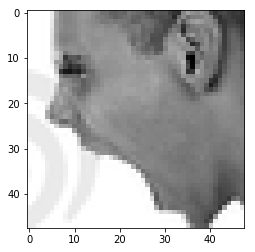

> true emotion: angry
> predicted emotion: angry


In [208]:
img_indx = np.uint32(np.random.rand()*(testingset.shape[0] - 1))
sample = x_testing[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict_classes(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> true emotion: %s\n> predicted emotion: %s' % (get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))